## Introduction

This is a small notebook to solve [Lights Out](https://en.wikipedia.org/wiki/Lights_Out_(game)) using some basic linear algebra techniques. The technique is based off of [this article](https://www.tandfonline.com/doi/abs/10.1080/0025570X.1998.11996658) with a few tweaks to accomadate different sized boards.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

As described in the article, I create a matrix with a few broadcasting tricks to avoid manually building each block. Then I just concatenate them using `np.block`. Each of the `B` blocks correspond to the activated cells in the same row, whereas the identity matrices are mostly opaque unless you see the entire matrix.

In [2]:
I = np.identity(5)
O = np.zeros((5,5))
B = np.identity(5)
B[1:, :-1] += np.identity(4)
B[:-1, 1:] += np.identity(4)

In [3]:
A = np.block([
    [B, I, O, O, O],
    [I, B, I, O, O],
    [O, I, B, I, O],
    [O, O, I, B, I],
    [O, O, O, I, B],
]).astype(bool)

Here's what the entire matrix looks like. Each column corresponds to the lights which will be affected by flipping that column. Every 5 rows correspond to a row in the original 5x5 matrix. 

Essentially this is a matrix whose domain is the action space and it's codomain is the game state. And each action is just clicking a cell such as (2, 3) which on this matrix would be the column `2*5 + 3 = 13`, therefore the corresponding cells on the y-axis get flipped.

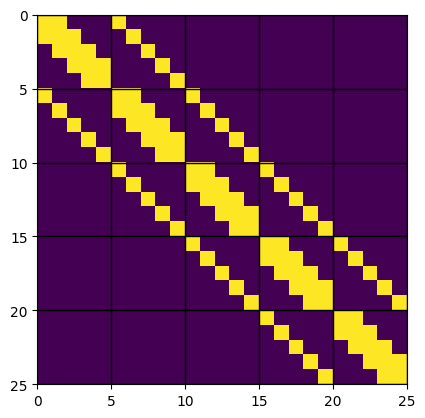

In [4]:
plt.imshow(A)
plt.xticks(np.arange(-0.5, 25, 5), np.arange(0, 26, 5))
plt.yticks(np.arange(-0.5, 25, 5), np.arange(0, 26, 5))
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

Here's just an example. The goal is to flip cells until the entire grid if full of ones. We'll flatten it so we don't have to do any tensor math, just matrices.

But because we want to solve the puzzle, it involves us finding the moves which brought that state from the fully on-state. We're given the output of having performed some vector of actions $\vec{x}$ where $x_i$ is a cell which is either 1 or 0 representing whether it was clicked an even or odd number of times as the order doesn't matter and clicking a cell twice is the same as not clicking it at all.

So, we know we want to find $\vec{x}$, because we can just click everything which was 1 to once again cancel its effect, yielding us the original fully on state.

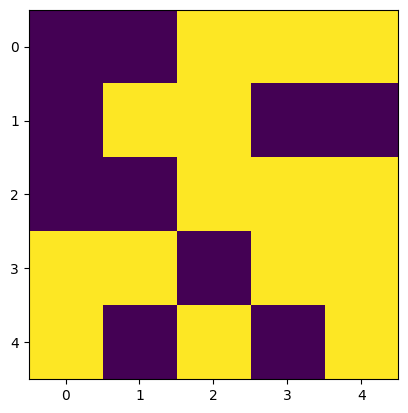

In [5]:
b = np.array([
    [0, 0, 1, 1, 1],
    [0, 1, 1, 0, 0],
    [0, 0, 1, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1],
], dtype=bool)
plt.imshow(b)
b = b.flatten().reshape((1, -1))

Now, an obvious first step would be to invert $A$, but if you try doing it (`np.linalg.inv(A)`) you'll see that the matrix is singular and its determinant is zero.

Usually, this either means our map has no solution or an infinite number of solutions. For now we'll only look at the case where there are solutions. Though, in fact, there cannot be an infinite number of solutions, but at most 4. This is becasue the field we are in does not have an infinite number of values like $\mathbb{R}$ but only 2 because it's binary ($\mathbb{Z}/2$), it's doubled because the null space consists of two dimensions as we'll see.

In [6]:
def my_rref(A):
    # Phase 1
    for c in range(A.shape[0]):
        # Step 1
        r = np.argmax(A[c:, c])+c
        tmp = A[r, :].copy()
        A[r, :], A[c, :] = A[c, :], tmp
        yield
        # Step 2
        for i in range(c+1, A.shape[0]):
            A[i] ^= A[i, c] & A[c]
        yield
    # Phase 2
    for c in range(A.shape[0]-1, 0, -1):
        yield
        val = A[c, -1]
        for i in np.argwhere(A[:c, c]==1):
            A[i, c] = 0
            A[i, -1] ^= val

Both scipy and numpy don't have any direct Gaussian elimination function, and SymPy doesn't allow us to specify that we're using the $\mathbb{Z}/2$ field (or any field for that matter), so I made my own. I've made it into a generator so you can see each step.

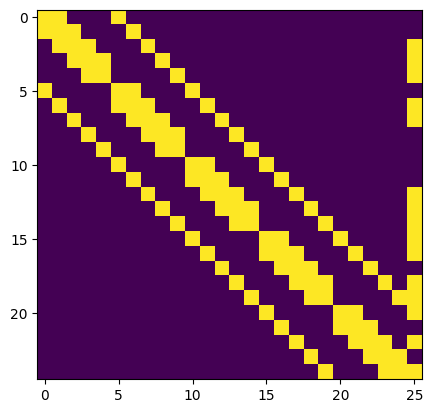

In [7]:
A_rref = np.concatenate([A, b.T], axis=1)
plt.imshow(A_rref)
gen = my_rref(A_rref)

Step through each iteration by running the cell until it raises an exception and see it work.

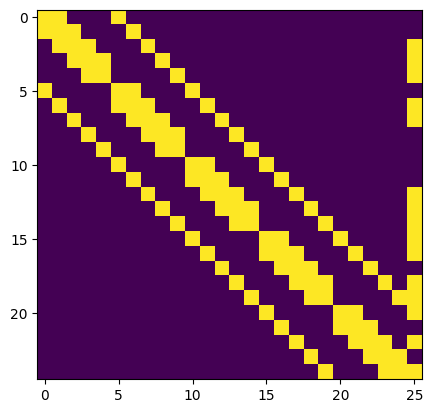

In [8]:
try:
    next(gen)
    plt.imshow(A_rref)
except StopIteration:
    print("Done iterating")
    plt.imshow(A_rref)

Or don't...

In [ ]:
try:
    while True:
        next(gen)
except StopIteration:
    plt.imshow(A_rref)

If you stepped through, you'd see that after it completed phase 1, there already were two rows which were completely empty. This being the null space, whose values are at our discretion. This way we can generate $\text{dim}(null(A)) \times \text{len}(\mathbb{Z}/2) = 4$ solutions, but I've chosen to assume it to be 1 for both dimensions, you can change the function to generate the remaining three solutions.

Note: if you used a different matrix, it may be possible that the last column in the final two rows were on, this is one of the scenarios where the system is unsolvable

Now I convert the final column into moves, if you actually play the [game](https://www.chiark.greenend.org.uk/~sgtatham/puzzles/js/flip.html), you'll see that it works. Well, it does the exact opposite of what you want if copied the white squares to be true, but this is the part of it being the inverse and not getting to that state. To find the actual solution, just do $1-b$ instead of just b for the augmented matrix.

In [10]:
for i, v in enumerate(A_rref[:, -1]):
    if v:
        r, c = divmod(i, 5)
        print(f'{r+1} {c+1}')

1 2
1 4
2 1
2 2
2 3
3 2
3 3
4 2
4 5
5 2


I packaged all of that which was for the 5x5 case into the general nxn case. Notice that some values don't have any null space, so there's no risk of having an invalid solution.

Currently, this does not handle cases where there is no solution, but it's a pretty easy check to implement.

In [11]:
def gen_matrix(n: int):
    I = np.identity(n)
    B = np.identity(n)
    O = np.zeros((n,n))
    B[1:, :-1] += np.identity(n-1)
    B[:-1, 1:] += np.identity(n-1)

    idx = [-1, 0, 1]
    rows = []
    for i in range(n):
        row = [O for _ in range(i-1)]
        for p, v in enumerate(idx):
            if v+i in range(n):
                row.append(B if p%2 else I)
        for _ in range(n-i-2):
            row.append(O)
        rows.append(row)
    return np.array(np.block(rows), dtype=bool)

def gauss_Z2(A):
    for c in range(A.shape[0]):
        r = np.argmax(A[c:, c])+c
        tmp = A[r, :].copy()
        A[r, :], A[c, :] = A[c, :], tmp
        for i in range(c+1, A.shape[0]):
            A[i] ^= A[i, c] & A[c]
    return A
def jordan_Z2(A, augmented=True):
    for c in range(A.shape[0]-1, 0, -1):
        val = A[c, -1]
        for i in np.argwhere(A[:c, c]==1):
            A[i, c] = 0
            if augmented: A[i, -1] ^= val
    return A

def rref_Z2(A):
    gauss_Z2(A)
    jordan_Z2(A)
    return A

def to_moves(A):
    ret = []
    for i, v in enumerate(A[:, -1]):
        if v:
            r, c = divmod(i, int((A.shape[0])**0.5))
            ret.append(f'{r+1} {c+1}')
    return ret

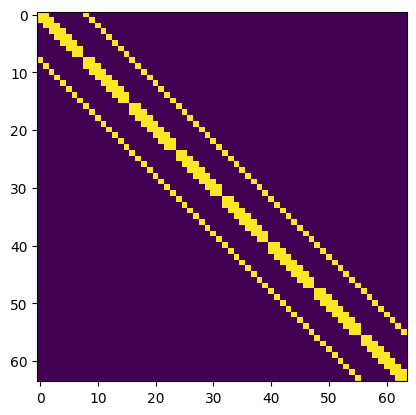

In [12]:
plt.imshow(gen_matrix(8))

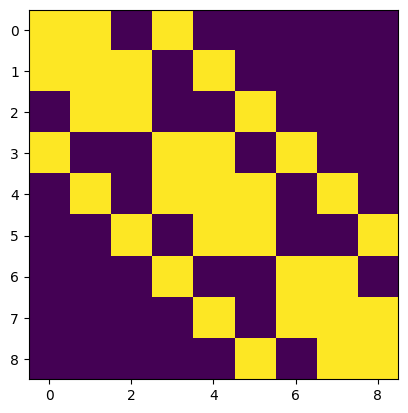

In [13]:
plt.imshow(gen_matrix(3))

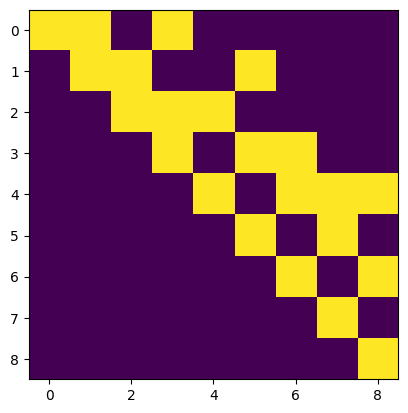

In [14]:
plt.imshow(gauss_Z2(gen_matrix(3)))

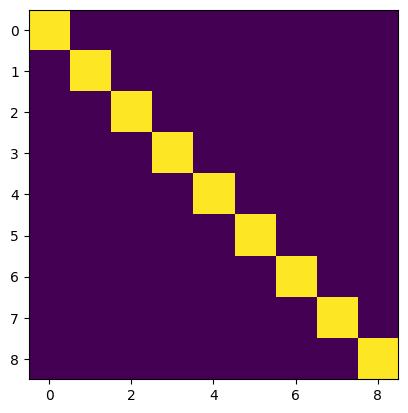

In [15]:
plt.imshow(jordan_Z2(gauss_Z2(gen_matrix(3)), False))

In [16]:
b_3 = 1-np.array([[
    0, 0, 0,
    0, 0, 1,
    1, 0, 1
]], dtype=bool)

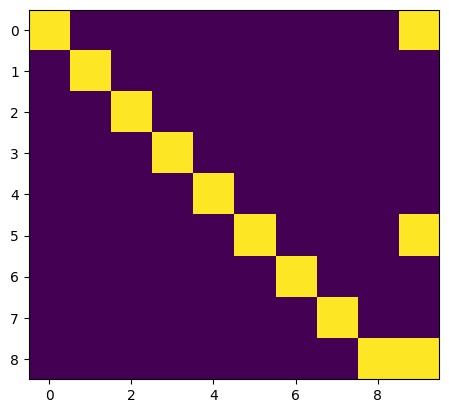

In [17]:
plt.imshow(rref_Z2(np.concatenate([gen_matrix(3), b_3.T], axis=1)))

In [18]:
to_moves(rref_Z2(np.concatenate([gen_matrix(3), b_3.T], axis=1)))

['1 1', '2 3', '3 3']

Here's surprisingly solvable and an unsolvable state. Try plotting it out for yourself and see how they fail.

In [ ]:
b_solvable = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0],
], dtype=bool)
plt.imshow(b_solvable)
b_solvable = b_solvable.flatten().reshape((1, -1))

b_unsolvable = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0],
], dtype=bool)
plt.imshow(b_unsolvable)
b_unsolvable = b_unsolvable.flatten().reshape((1, -1))

In [19]:
import ipywidgets as widgets
from IPython.display import display

class GridWidget(widgets.VBox):
    def __init__(self):
        super().__init__()
        self.rows = 5
        self.cols = 5
        self.grid = [[widgets.ToggleButton(value=False, layout=widgets.Layout(width='20px', height='20px')) for _ in range(self.cols)] for _ in range(self.rows)]
        self.output = widgets.Output()
        self.submit_button = widgets.Button(description='Submit')
        self.submit_button.on_click(self.on_submit)
        self.children = [widgets.HBox(row) for row in self.grid] + [self.submit_button, self.output]

    def on_submit(self, button):
        grid_values = [[button.value for button in row] for row in self.grid]
        with self.output:
            print('Moves to solve:')
            rows = []
            for row in grid_values:
                rows.append(row)
            b = np.array(rows).flatten().reshape(1, -1)
            for move in to_moves(rref_Z2(np.concatenate([gen_matrix(5), b.T], axis=1))):
                print(move)

grid_widget = GridWidget()
display(grid_widget)


GridWidget(children=(HBox(children=(ToggleButton(value=False, layout=Layout(height='20px', width='20px')), Tog…